<a href="https://colab.research.google.com/github/jasleenkaursandhu/Reproducing-chest-xray-report-generation-boag/blob/main/01_mimic_cxr_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries and mount google drive
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import tqdm
from collections import defaultdict
import pickle
import gzip
import random
import re
import warnings
!pip install pydicom
from collections import Counter, defaultdict
from google.colab import drive
from time import gmtime, strftime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 24.0 MB/s eta 0:00:00


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/mimic-cxr-project'
!mkdir -p {base_path}/data
!mkdir -p {base_path}/output

Mounted at /content/drive


In [3]:
# Import the report parser module
import sys
sys.path.append(f"{base_path}/modules")
from report_parser import parse_report, MIMIC_RE
print("Successfully imported report parser module")

Successfully imported report parser module


In [4]:
# Load and preprocess data shapes
record_list_path = os.path.join(base_path, 'cxr-record-list.csv')
study_list_path = os.path.join(base_path, 'cxr-study-list.csv')

# Load the CSV files
df_studies = pd.read_csv(study_list_path)
df_records = pd.read_csv(record_list_path)

# Print the counts from these files
print('Images based on record list: %6d' % len(df_records))
print('Reports based on study list: %6d' % len(df_studies))

# Merge them to create a single dataframe with the columns we need
df = pd.merge(
    df_studies[['subject_id', 'study_id']],
    df_records[['subject_id', 'study_id', 'dicom_id']],
    on=['subject_id', 'study_id']
)

# Add dicom_is_available column
df['dicom_is_available'] = True

print(df.shape)
display(df.head())

print('unique subjects: %6d' % len(set(df['subject_id'])))
print('unique studies: %6d' % len(set(df['study_id'])))
print('unique   dicoms: %6d' % len(set(df['dicom_id'])))

Images based on record list: 377110
Reports based on study list: 227835
(377110, 4)


,subject_id,study_id,dicom_id,dicom_is_available
0,10000032,50414267,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,True
1,10000032,50414267,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,True
2,10000032,53189527,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,True
3,10000032,53189527,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,True
4,10000032,53911762,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,True


unique subjects:  65379
unique studies: 227835
unique   dicoms: 377110


In [5]:
# Extracting view positions
import pydicom
import gzip
import tqdm

# Initialize positions dictionary
positions = {}

# Get column names
columns = df.columns

# Process all rows in the dataframe - using the full dataset
for vals in tqdm.tqdm(df.values):
    row = dict(zip(columns, vals))
    dicom_file = str(row['dicom_id']) + '.dcm'

    # Construct paths based on your file structure
    subject_id = row['subject_id']
    subject_prefix = f"p{str(subject_id)[:2]}"
    subject_dir = f"p{subject_id}"
    study_id = row['study_id']
    study_dir = f"s{study_id}"

    # Full path to the DICOM file
    dicom_path = os.path.join(base_path, 'files', subject_prefix, subject_dir, study_dir, dicom_file)

    # Check if file exists
    if os.path.exists(dicom_path):
        try:
            plan = pydicom.dcmread(dicom_path, stop_before_pixels=True)
            if hasattr(plan, 'ViewPosition'):
                view_position = plan.ViewPosition
                positions[row['dicom_id']] = view_position
        except Exception as e:
            # Just continue without printing errors to avoid cluttering output
            pass

# Save view positions
view_positions_path = os.path.join(base_path, 'view_positions.pkl')
with open(view_positions_path, 'wb') as f:
    pickle.dump(positions, f)

print(f"Extracted view positions for {len(positions)} images")

# View position distribution
position_counts = pd.Series(positions.values()).value_counts()
print("\nView position distribution:")
print(position_counts)

100%|██████████| 377110/377110 [2:26:18<00:00, 42.96it/s]


Extracted view positions for 8363 images

View position distribution:
AP         8206
             58
PA           35
LATERAL      33
LL           31
Name: count, dtype: int64


In [6]:
# Load the view positions we saved earlier
view_positions_path = os.path.join(base_path, 'view_positions.pkl')
with open(view_positions_path, 'rb') as f:
    view_positions = pickle.load(f)

print(f"Loaded {len(view_positions)} view positions")
print("Sample view positions:", dict(list(view_positions.items())[:2]))

Loaded 8363 view positions
Sample view positions: {'68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714': 'AP', 'fffabebf-74fd3a1f-673b6b41-96ec0ac9-2ab69818': 'AP'}


In [7]:
# Build dataset of (image, report) pairs organized by patient
data = defaultdict(list)

# Process rows to find AP images with reports
columns = df.columns
for vals in tqdm.tqdm(df.values):
    row = dict(zip(columns, vals))

    # Construct paths
    subject_id = row['subject_id']
    subject_prefix = f"p{str(subject_id)[:2]}"
    subject_dir = f"p{subject_id}"
    study_id = row['study_id']
    study_dir = f"s{study_id}"

    dicom_file = f"{row['dicom_id']}.dcm"
    dicom_path = os.path.join(base_path, 'files', subject_prefix, subject_dir, study_dir, dicom_file)

    report_file = f"{study_dir}.txt"
    report_path = os.path.join(base_path, 'files', subject_prefix, subject_dir, report_file)

    # Check if files exist
    if not os.path.exists(dicom_path) or not os.path.exists(report_path):
        continue

    # Only AP images
    dicom_id = row['dicom_id']
    if dicom_id not in view_positions or view_positions[dicom_id] != 'AP':
        continue

    # Check if report has findings section
    try:
        with open(report_path, 'r') as f:
            report_text = f.read().lower()
        if 'findings' in report_text:
            item = (dicom_path, report_path)
            data[row['subject_id']].append(item)
    except Exception as e:
        pass

print(f"Built dataset with {len(data)} patients")
print(f"Total image-report pairs: {sum(len(items) for items in data.values())}")

100%|██████████| 377110/377110 [40:55<00:00, 153.56it/s] 

Built dataset with 1596 patients
Total image-report pairs: 3114


In [8]:
# List of unique dicom IDs
dicom_ids = set()
for subject_id, items in list(data.items()):
    for dicom_path, report_path in items:
        dicom_id = os.path.basename(dicom_path).split('.')[0]
        dicom_ids.add(dicom_id)

print(f"Found {len(dicom_ids)} unique DICOM IDs")

Found 3114 unique DICOM IDs


In [9]:
# List of subject IDs
subject_ids = list(data.keys())

# Create train/test split
subject_ids = list(subject_ids)  # Create a copy
random.shuffle(subject_ids)  # Shuffle randomly

n = len(subject_ids)
split_ind = int(0.7 * n)  # 70% training, 30% testing
train_ids = subject_ids[:split_ind]
test_ids = subject_ids[split_ind:]

print('Train subjects:', len(train_ids))
print('Test subjects:', len(test_ids))

Train subjects: 1117
Test subjects: 479


In [10]:
# Check how many images are in each split
train_images = 0
test_images = 0

for subject_id in train_ids:
    train_images += len(data[subject_id])

for subject_id in test_ids:
    test_images += len(data[subject_id])

print(f"Train images: {train_images}")
print(f"Test images: {test_images}")
print(f"Total images: {train_images + test_images}")

Train images: 2243
Test images: 871
Total images: 3114


In [11]:
# Create dataframes for train/test sets
train_rows = []
for subject_id in train_ids:
    for dicom_path, report_path in data[subject_id]:
        dicom_id = os.path.basename(dicom_path).split('.')[0]
        study_id = os.path.basename(os.path.dirname(dicom_path))
        train_rows.append({
            'subject_id': subject_id,
            'study_id': study_id.replace('s', ''),  # Remove the 's' prefix
            'dicom_id': dicom_id
        })

test_rows = []
for subject_id in test_ids:
    for dicom_path, report_path in data[subject_id]:
        dicom_id = os.path.basename(dicom_path).split('.')[0]
        study_id = os.path.basename(os.path.dirname(dicom_path))
        test_rows.append({
            'subject_id': subject_id,
            'study_id': study_id.replace('s', ''),  # Remove the 's' prefix
            'dicom_id': dicom_id
        })

train_df = pd.DataFrame(train_rows)
test_df = pd.DataFrame(test_rows)

# Write to file
train_df.to_csv(os.path.join(base_path, 'data', 'train.tsv'), sep='\t', index=False)
test_df.to_csv(os.path.join(base_path, 'data', 'test.tsv'), sep='\t', index=False)

print(f"Saved {len(train_df)} training samples to data/train.tsv")
print(f"Saved {len(test_df)} test samples to data/test.tsv")

Saved 2243 training samples to data/train.tsv
Saved 871 test samples to data/test.tsv


10000032 (2)
	-----------
	Patient ID: 10000032
	View Position: AP


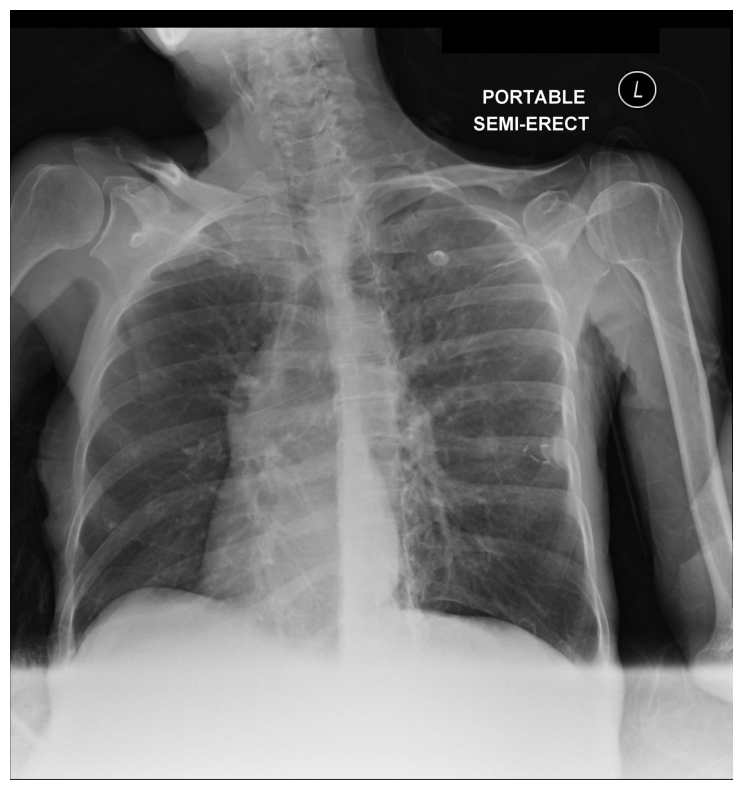

	Findings: single frontal view of the chest provided. there is no focal consolidation, effusion, or pneumothorax. the cardiomediastinal silhouette is normal. again seen are multiple clips projecting over the left breast and remote left-sided rib fractures. no free air below the right hemidiaphragm is seen.
	-----------
	Patient ID: 10000032
	View Position: AP


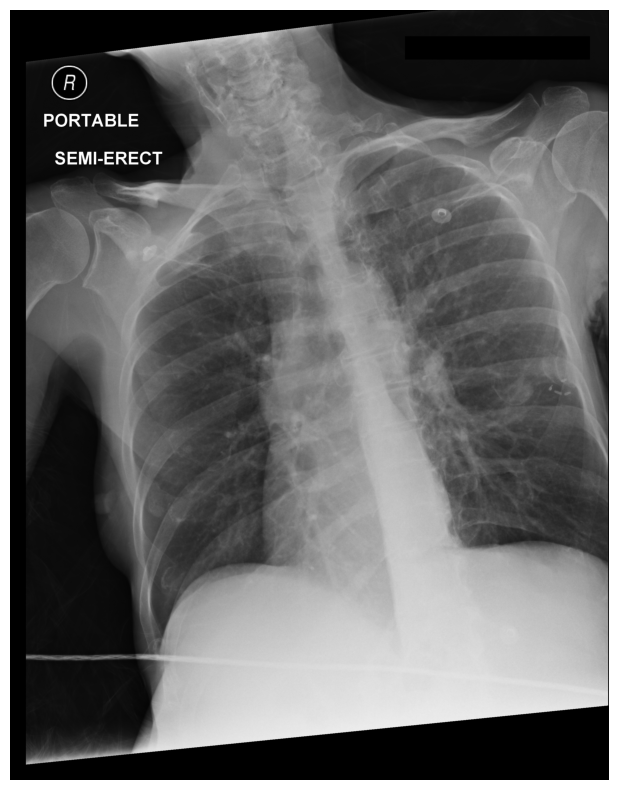

	Findings: single frontal view of the chest provided. there is no focal consolidation, effusion, or pneumothorax. the cardiomediastinal silhouette is normal. again seen are multiple clips projecting over the left breast and remote left-sided rib fractures. no free air below the right hemidiaphragm is seen.

10000935 (1)
	-----------
	Patient ID: 10000935
	View Position: AP


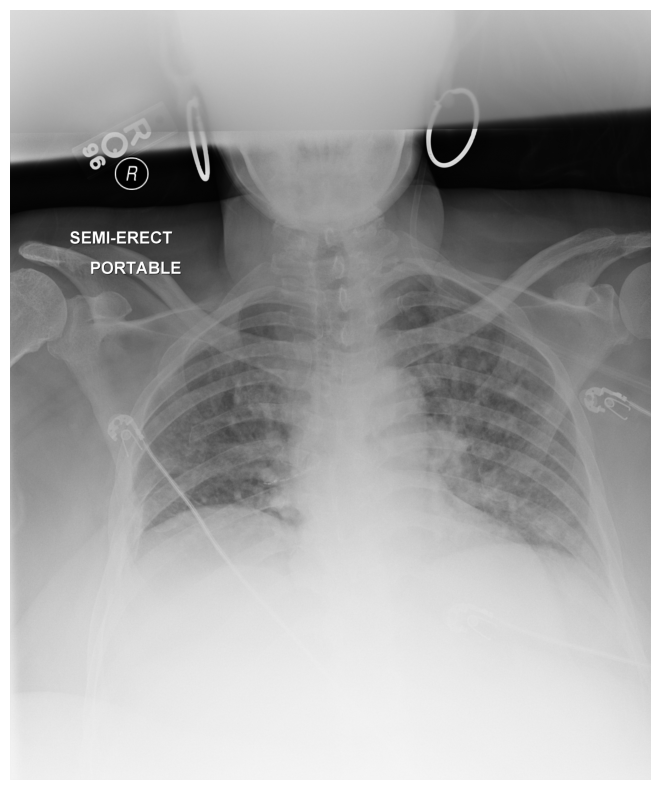

	Findings: lung volumes are low. this results in crowding of the bronchovascular structures. there may be mild pulmonary vascular congestion. the heart size is borderline enlarged. the mediastinal and hilar contours are relatively unremarkable. innumerable nodules are demonstrated in both lungs, more pronounced in the left upper and lower lung fields compatible with metastatic disease. no new focal consolidation, pleural effusion or pneumothorax is seen, with chronic elevation of right hemidiaphragm again seen. the patient is status post right lower lobectomy. rib deformities within the right hemithorax is compatible with prior postsurgical changes.

10001401 (1)
	-----------
	Patient ID: 10001401
	View Position: AP


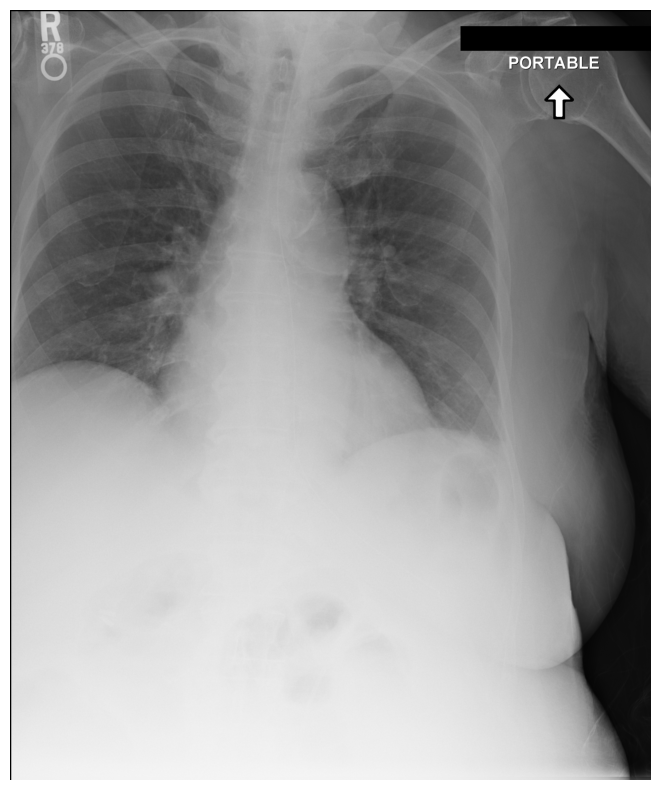

	Findings: the right costophrenic angle is not imaged. otherwise, the lungs are clear. the heart size is upper limits of normal. enteric tube courses below the level of the diaphragm. there is no pneumothorax.



In [12]:
# Load a few images to spot check
n = min(3, len(data))
first_n = dict(list(data.items())[:n])

for subject_id, items in first_n.items():
    print(f'{subject_id} ({len(items)})')

    for j, (dicom_path, report_path) in enumerate(items[:2]):  # Show up to 2 images per patient
        try:
            # Read DICOM file
            plan = pydicom.dcmread(dicom_path)

            # Convert to image
            pixel_array = plan.pixel_array
            image = Image.fromarray(np.uint8(pixel_array/pixel_array.max()*255))

            # Parse report
            parsed_report = parse_report(report_path)

            # Display information
            print('\t-----------')
            print('\tPatient ID:', plan.PatientID if hasattr(plan, 'PatientID') else 'Unknown')
            print('\tView Position:', plan.ViewPosition if hasattr(plan, 'ViewPosition') else 'Unknown')

            plt.figure(figsize=(10, 10))
            plt.imshow(image, cmap='gray')
            plt.axis('off')
            plt.show()

            if 'findings' in parsed_report:
                print("\tFindings:", parsed_report['findings'])
            else:
                print('\tFindings: None')

        except Exception as e:
            print(f"\tError processing {dicom_path}: {e}")

    print('\t===================================================')
    print()